# REAL ESTATE PRICE REGRESSION

## SETUP

### Settings

In [15]:
reread_clipboard = False # read execution order from clipboard
rerun_embeddings = False # OpenAI call for embeddings 
rerun_autoencoder = False # autoencoder
rerun_one_step = True # one step vectorizer
verbose = True # Tensorflow training verbosity
hidden_size_1 = 1024 # parameters for the autoencoder
hidden_size_2 = 512 
hidden_size_3 = 256
hidden_size_4 = 128
latent_size = 64
batch_size = 1024
epochs = 1500
catboost_task_type = 'CPU'
test_perc = 0.2
random_seed = 42

### Imports

In [2]:
import random
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
from IPython.display import Image 

from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm
tqdm.pandas()
import datetime
start = datetime.datetime.now()
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
pd.set_option('display.min_rows', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', None)

In [17]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.callbacks import EarlyStopping
from random import randint
tf.random.set_seed(random_seed)
#https://medium.com/analytics-vidhya/autoencoders-with-tensorflow-2f0a7315d161

In [18]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import timeit
import neptune
from neptune.utils import stringify_unsupported
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

### Some Common Functions

In [19]:
def vc(series):
    return series.value_counts(dropna = False)
def myanalyzeassets(seta, setb):
    seta = set(seta)
    setb = set(setb)
    print("in first only" + str(len(seta - setb)))
    print("in second only" + str(len(setb - seta)))
    print("in both" + str(len(seta.intersection(setb))))
    print("length of first" + str(len(seta)))
    print("length of second" + str(len(setb)))
def myplothisttopperc(myseries, myperc = 99, figsize=(10, 3)):
    mycol = np.array(myseries)
    cutoff = myperc / 100
    nr = int(len(mycol)*cutoff)
    myplothist(mycol[np.argsort(mycol)[:nr]], 100)
def myplothist(series, bins = 100, figsize=(10, 3)):
    nump = np.array(series)
    plt.figure(figsize = figsize)
    plt.hist(nump, bins = bins)
    plt.show()

### Reading in the Data

In [20]:
if reread_clipboard == True:
    model_run_dictionaries = pd.read_clipboard().T
    model_run_dictionaries = [{index: row[col] for index, row in model_run_dictionaries.iterrows()} for col in model_run_dictionaries.columns]
    with open('../pickles/04/model_run_dictionaries.pkl', 'wb') as f:
        pickle.dump(model_run_dictionaries, f)
else: 
    with open('../pickles/04/model_run_dictionaries.pkl', 'rb') as f:
        model_run_dictionaries = pickle.load(f)    

In [21]:
df_selected_projected = pd.read_pickle('../pickles/03/selected_projected_df_from_03.pkl')
df_aptms = pd.read_pickle('../pickles/03/aptms_df.pkl') 

## OPTIMIZATION

### High Level Overview - The Main Function in Pseudocode

In [3]:
Image(url="features.png", width=2000) 

### Get Ready

In [8]:
def enrich_data_and_read_with_leakage(df_selected_projected): 
    """
    THERE IS A TRAINING-TESTING LEAKAGE HERE, AS THE APPEARANCE FREQUENCIES ARE CALCULATED ON THE WHOLE DATASET.
    Enriches the keyword detections dataframe with e1 - e1 is minor category, e2 is keyword and Key is major category in the output. 
    Returns the all_columns variable and the appearance frequencies dataframe.
    
    Parameters:
    df_selected_projected (DataFrame): The keyword detections dataframe.
    
    Returns:
    df_selected_projected (DataFrame): The enriched keyword detections dataframe.
    all_columns (list): List of all columns in the appearance frequencies dataframe.
    df_appearance_freqs (DataFrame): The keyword-minor-major-category frequency dataframe.
    """
    df_appearance_freqs = pd.read_pickle('../pickles/otherPickles/appearance_freqs_df.pkl')
    all_columns = sorted(df_appearance_freqs.feature_e1.tolist())
    df_selected_projected = df_selected_projected.merge(df_appearance_freqs[['e2', 'e1']], how='left', on='e2')
    df_selected_projected['feature_e1'] = df_selected_projected['Key'] + '---' + df_selected_projected['e1']
    return df_selected_projected, all_columns, df_appearance_freqs

### Filter and Train-Test Split

In [9]:
def filter_and_split_to_train_test(df_aptms, df_selected_projected, model_run_dictionary, plot_param = 99.9):
    """
    Filters and splits the data into train and test sets based on the given criteria put forth in the current model_run_dictionary.

    Args:
        df_aptms (DataFrame): The input DataFrame containing the main apartment dataframe.
        df_selected_projected (DataFrame): The input DataFrame containing the keyword detections dataframe.
        model_run_dictionary (dict): A dictionary containing model run parameters.
        plot_param (float, optional): The parameter for plotting. Defaults to 99.9.

    Returns:
        tuple: A tuple containing the filtered DataFrame (df_aptms - the main apartment dataframe), 
        the filtered DataFrame (df_selected_projected - the keyword detections dataframe),
               the indices of the train set (train_idx), and the indices of the test set (test_idx).
    """
    if model_run_dictionary['model_split_criteria'] == 'price':
        df_aptms = df_aptms[df_aptms.price < model_run_dictionary['model_price_limit']]
        myplothisttopperc(df_aptms.price, plot_param)
    elif model_run_dictionary['model_split_criteria'] == 'm2_price':
        ds_m2_price = df_aptms.price / df_aptms.Uldpind
        df_aptms = df_aptms[ds_m2_price < model_run_dictionary['model_price_limit']]
        myplothisttopperc(df_aptms.price / df_aptms.Uldpind, plot_param)
    else: 
        raise Exception(f"unhandled model split criteria: {model_run_dictionary['model_split_criteria']}")
        
    df_selected_projected = df_selected_projected[df_selected_projected.idx.isin(df_aptms.index.tolist())]
    
    train_test = df_aptms.index.tolist()
    random.seed(random_seed)
    random.shuffle(train_test)
    test_idx = train_test[:int(test_perc*len(train_test))]
    train_idx = train_test[int(test_perc*len(train_test)):]
    return df_aptms, df_selected_projected, train_idx, test_idx

def apply_tt_split(df_aptms, df_selected_projected, train_idx, test_idx):
    """
    Splits the given dataframes into train and test sets based on the provided indices.
    
    Parameters:
    - df_aptms (DataFrame): The dataframe containing apartment dataframe.
    - df_selected_projected (DataFrame): The dataframe containing the keyword detections dataframe.
    - train_idx (list): The list of indices to be used for the train set.
    - test_idx (list): The list of indices to be used for the test set.
    
    Returns:
    - df_selected_projected_train (DataFrame): The train set of the keyword detections dataframe.
    - df_aptms_train (DataFrame): The train set of the apartment dataframe.
    - df_selected_projected_test (DataFrame): The test set of the keyword detections dataframe.
    - df_aptms_test (DataFrame): The test set of the apartment dataframe.
    """
    df_selected_projected_train = df_selected_projected[df_selected_projected.idx.isin(train_idx)].copy()
    df_selected_projected_test = df_selected_projected[df_selected_projected.idx.isin(test_idx)].copy()
    
    df_aptms_train = df_aptms[df_aptms.index.isin(train_idx)].copy()
    df_aptms_test = df_aptms[df_aptms.index.isin(test_idx)].copy()
    
    return df_selected_projected_train, df_aptms_train, df_selected_projected_test, df_aptms_test

### Understand Appearance Frequencies

In [10]:
def read_previous_data_relative_absolute_frequencies_without_leakage_after_split_not_turned_on(df_selected_projected): 
    ### create dense-sparse separation: dense will one-hot encode the more prevalent features, sparse will use two categorical columns, losing only a little bit of the remaninig information
    ## (e.g. 5k out of 208k, in the first trial example settings set)
    ## df_appearance_freqs shows the relative frequency of each minor category within each major category
    #df_appearance_freqs = df_selected_projected.groupby(['Key', 'e2']).count().reset_index(drop = False).sort_values(['Key', 'idx'], ascending = [True, False])
    #df_appearance_freqs = df_appearance_freqs.merge(df_appearance_freqs.groupby(['Key'])[['idx']].sum().reset_index().rename(columns = {'idx' : 'idx2'}), how = 'left', on = 'Key')
    #df_appearance_freqs.idx2 = df_appearance_freqs.idx / df_appearance_freqs.idx2
    #
    #df_appearance_freqs = df_appearance_freqs.merge(pd.read_pickle('../pickles/otherPickles/appearance_df.pkl'), on = ['Key', 'e2'], how = 'left')
    #df_appearance_freqs['feature'] = df_appearance_freqs['Key'] + '---' + df_appearance_freqs['e2']
    #df_appearance_freqs['LongFeature'] = df_appearance_freqs['LongKey'] + '---' + df_appearance_freqs['e2']
    #df_appearance_freqs['LongFeatureEN'] = df_appearance_freqs['LongKey'] + '---' + df_appearance_freqs['English']

    return df_appearance_freqs, all_columns

### Add Keyword Based Features

#### Dense

In [11]:
def run_gpt_dense_features(df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, model_run_dictionary, df_selected_projected_test, df_aptms_index_test):
    def add_remaining_columns_as_zeros(all_columns, df):
        """
        Adds the missing columns as zeros to the given DataFrame.

        Parameters:
        - all_columns (list): List of all column names.
        - df (pandas.DataFrame): The DataFrame to add the columns to.

        Returns:
        - pandas.DataFrame: The DataFrame with the added missing columns as zeros.
        """
        added_columns = list(set(all_columns) - set(df.columns))
        for column in added_columns:
            df[column] = 0
        return df
        
    def get_feature_lists(df_appearance_freqs, model_run_dictionary):
        """
        Get feature lists based on appearance frequencies and model run dictionary.

        Args:
            df_appearance_freqs (DataFrame): keyword-minor-major-category frequency dataframe.
            model_run_dictionary (dict): Dictionary containing model run parameters.

        Returns:
            tuple: these three small dataframes containing feature names in 'e1' column
                - df_dense_features_one: used for one-hot-encoding based on the relative frequencies (uses global parameter model_run_dictionaries[dense_sparse_relative_boundary])
                - df_dense_features_two: used for one-hot-encoding based on the absolute frequencies [of each minor category within the entire dataset] (in order to not double-include, it uses 
                                                                variables model_run_dictionaries[dense_sparse_relative_boundary] and model_run_dictionaries[dense_sparse_absolute_boundary])
                - df_sparse_features: used for encoding in two categorical columns, later - the rest of the features, not included above, go there. 
        """
        df_dense_features_one = df_appearance_freqs[df_appearance_freqs.idx2_e1 >= model_run_dictionary['dense_sparse_relative_boundary']].copy()
        df_dense_features_two = df_appearance_freqs[(df_appearance_freqs.idx_e1 >= model_run_dictionary['dense_sparse_absolute_boundary']) & \
                                                    (df_appearance_freqs.idx2_e1 < model_run_dictionary['dense_sparse_relative_boundary'])].copy()
        df_sparse_features = df_appearance_freqs[(df_appearance_freqs.idx2_e1 < model_run_dictionary['dense_sparse_relative_boundary']) & (\
                                                    df_appearance_freqs.idx_e1 < model_run_dictionary['dense_sparse_absolute_boundary'])].copy()
        return df_dense_features_one, df_dense_features_two, df_sparse_features
    
    def get_sources_for_wide_dfs(df_selected_projected_train, df_dense_features_one, df_dense_features_two, df_sparse_features, df_selected_projected_test):
        """
        Retrieves the required sources for creating wide dataframes.

        Parameters:
        - df_selected_projected_train: keyword detections dataframe - for training
        - df_dense_features_one: DataFrame containing dense features one
        - df_dense_features_two: DataFrame containing dense features two
        - df_sparse_features: DataFrame containing sparse features
        - df_selected_projected_test: keyword detections dataframe - for testing

        Returns:
        - gpt_dense_source_one: DataFrame containing one-hot-encoded data for dense features one - long format
        - gpt_dense_source_two: DataFrame containing one-hot-encoded data for dense features two - long format
        - gpt_sparse_source: DataFrame containing data for creating categorical columns - long fromat
        - gpt_dense_source_one_test: DataFrame containing one-hot-encoded test data for dense features one - long format
        - gpt_dense_source_two_test: DataFrame containing one-hot-encoded test data for dense features two - long format
        - gpt_sparse_source_test: DataFrame containing test data for creating categorical columns - long format
        """
        # creates the two one-hot-encoded long dataframes
        gpt_dense_source_one = df_selected_projected_train[df_selected_projected_train.e1.isin(df_dense_features_one.e1.tolist())].copy()
        gpt_dense_source_two = df_selected_projected_train[df_selected_projected_train.e1.isin(df_dense_features_two.e1.tolist())].copy()

        # creates the dataframe later used for creating categorical columns - long one
        gpt_sparse_source = df_selected_projected_train[df_selected_projected_train.e1.isin(df_sparse_features.e1.tolist())].copy()

        # same for test
        gpt_dense_source_one_test = df_selected_projected_test[df_selected_projected_test.e1.isin(df_dense_features_one.e1.tolist())].copy()
        gpt_dense_source_two_test = df_selected_projected_test[df_selected_projected_test.e1.isin(df_dense_features_two.e1.tolist())].copy()
        gpt_sparse_source_test = df_selected_projected_test[df_selected_projected_test.e1.isin(df_sparse_features.e1.tolist())].copy()

        return gpt_dense_source_one, gpt_dense_source_two, gpt_sparse_source, gpt_dense_source_one_test, gpt_dense_source_two_test, gpt_sparse_source_test
    
    def get_dense_wide_table(gpt_dense_source_one_train, gpt_dense_source_two_train, df_aptms_index_train, gpt_dense_source_one_test, gpt_dense_source_two_test, df_aptms_index_test):
        """
        Generate wide versions of the dense features and create the final dense dataframe.

        Parameters:
        gpt_dense_source_one_train (DataFrame): The first dense source train dataframe - long format
        gpt_dense_source_two_train (DataFrame): The second dense source train dataframe - long format
        df_aptms_index_train (DataFrame): The train index dataframe from the main apartement dataframe.
        gpt_dense_source_one_test (DataFrame): The first dense source test dataframe - long format.
        gpt_dense_source_two_test (DataFrame): The second dense source test dataframe - long format.
        df_aptms_index_test (DataFrame): The test index dataframe from the main apartement dataframe.

        Returns:
        gpt_dense_source_final_train (DataFrame): The final dense train dataframe.
        gpt_dense_source_final_test (DataFrame): The final dense test dataframe.
        """
        ## work with the dense part of the data
        # create proper feature names - containing both the major and the minor category
        gpt_dense_source_one_train['feature_e1'] = gpt_dense_source_one_train['Key'] + '---' + gpt_dense_source_one_train['e1']
        gpt_dense_source_two_train['feature_e1'] = gpt_dense_source_two_train['Key'] + '---' + gpt_dense_source_two_train['e1']
        
        # create two dataframes with wide versions of the dense features
        gpt_dense_source_one_wide = gpt_dense_source_one_train.pivot_table(index='idx', columns='feature_e1', values='e1', aggfunc='count').fillna(0)
        gpt_dense_source_one_wide_np = (np.array(gpt_dense_source_one_wide) != 0) * 1 # after introducing e1, this table was no longer binary, making it binary now
        gpt_dense_source_one_wide = pd.DataFrame(gpt_dense_source_one_wide_np, index=gpt_dense_source_one_wide.index, columns=gpt_dense_source_one_wide.columns)
        gpt_dense_source_two_wide = gpt_dense_source_two_train.pivot_table(index='idx', columns='feature_e1', values='e1', aggfunc='count').fillna(0)
        gpt_dense_source_two_wide_np = (np.array(gpt_dense_source_two_wide) != 0) * 1 # after introducing e1, this table was no longer binary, making it binary now
        gpt_dense_source_two_wide = pd.DataFrame(gpt_dense_source_two_wide_np, index=gpt_dense_source_two_wide.index, columns=gpt_dense_source_two_wide.columns)

        ## create the final dense dataframe and sort its columns
        gpt_dense_source_final_train = pd.DataFrame(df_aptms_index_train, columns=['idx']).merge(gpt_dense_source_one_wide, how='left', on='idx').merge(gpt_dense_source_two_wide, how='left', on='idx').set_index('idx').fillna(0)
        gpt_dense_source_final_train = gpt_dense_source_final_train[sorted(gpt_dense_source_final_train.columns)]

        # same for test + adding missing columns
        gpt_dense_source_one_test['feature_e1'] = gpt_dense_source_one_test['Key'] + '---' + gpt_dense_source_one_test['e1']
        gpt_dense_source_two_test['feature_e1'] = gpt_dense_source_two_test['Key'] + '---' + gpt_dense_source_two_test['e1']

        gpt_dense_source_one_wide_test = gpt_dense_source_one_test.pivot_table(index='idx', columns='feature_e1', values='e1', aggfunc='count').fillna(0)
        gpt_dense_source_one_wide_np_test = (np.array(gpt_dense_source_one_wide_test) != 0) * 1 # after introducing e1, this table was no longer binary, making it binary now
        gpt_dense_source_one_wide_test = pd.DataFrame(gpt_dense_source_one_wide_np_test, index=gpt_dense_source_one_wide_test.index, columns=gpt_dense_source_one_wide_test.columns)
        gpt_dense_source_two_wide_test = gpt_dense_source_two_test.pivot_table(index='idx', columns='feature_e1', values='e1', aggfunc='count').fillna(0)
        gpt_dense_source_two_wide_np_test = (np.array(gpt_dense_source_two_wide_test) != 0) * 1 # after introducing e1, this table was no longer binary, making it binary now
        gpt_dense_source_two_wide_test = pd.DataFrame(gpt_dense_source_two_wide_np_test, index=gpt_dense_source_two_wide_test.index, columns=gpt_dense_source_two_wide_test.columns)

        gpt_dense_source_final_test = pd.DataFrame(df_aptms_index_test, columns=['idx']).merge(gpt_dense_source_one_wide_test, how='left', on='idx').merge(gpt_dense_source_two_wide_test, how='left', on='idx').set_index('idx').fillna(0)

        # what columns to add
        all_dense_columns = sorted(gpt_dense_source_final_train.columns.tolist())
        # adding columns
        gpt_dense_source_final_test = add_remaining_columns_as_zeros(all_dense_columns, gpt_dense_source_final_test)
        gpt_dense_source_final_test = gpt_dense_source_final_test[sorted(gpt_dense_source_final_test.columns)]

        return gpt_dense_source_final_train, gpt_dense_source_final_test

    def dense_train_sanity_check(df_selected_projected, df_dense_features_one, df_dense_features_two, gpt_dense_source_final):
        """
        Performs a sanity check on the dense train data.

        Parameters:
        - df_selected_projected: keyword detections dataframe
        - df_dense_features_one: DataFrame containing the first set of dense features
        - df_dense_features_two: DataFrame containing the second set of dense features
        - gpt_dense_source_final: Dense matrix for the train data

        Returns:
        - d_all_dense: Total number of cells in the dense train matrix
        - d_full_dense: Number of non-zero cells in the dense train matrix
        """
        ## sanity check - are all the main occurencies ok, for dense train
        print(f'*The number of train data to be encoded: {df_selected_projected[df_selected_projected.e1.isin(pd.concat([df_dense_features_one.e1, df_dense_features_two.e1], axis = 0).tolist())].shape[0]}')
        print(f'*The numer of train non-zeroes in the encoded matrix: {(np.array(gpt_dense_source_final) != 0).sum()}')
        print('The two numbers may differ, as some detections used keyword synonyms for the same e1 minor features. DEBUGNB! Assertion itself has thus has been removed.')
        #assert df_selected_projected[df_selected_projected.e1.isin(pd.concat([df_dense_features_one.e1, df_dense_features_two.e1], axis = 0).tolist())].shape[0] == \
        #                                                                                                                (np.array(gpt_dense_source_final) != 0).sum()
        #print("All correctly cast to dense matrix half")
        d_all_dense = gpt_dense_source_final.shape[0]*gpt_dense_source_final.shape[1]
        print(f'*Dense train all cells: {d_all_dense}')
        d_full_dense = (np.array(gpt_dense_source_final) != 0).sum()
        print(f'*Dense train cells full: {d_full_dense}')
        print(f'*Percent full train, thus: {d_full_dense/d_all_dense}')

        return d_all_dense, d_full_dense

    
    """
    Runs the GPT dense features pipeline.

    Args:
        df_selected_projected_train (DataFrame): keyword detections train dataframe
        df_appearance_freqs (DataFrame): keyword-minor-major-category frequency dataframe.
        df_aptms_index_train (DataFrame): main train apartment dataframe indices. 
        model_run_dictionary (dict): The dictionary containing model run information.
        df_selected_projected_test (DataFrame): keyword detections test dataframe.
        df_aptms_index_test (DataFrame): The test dataframe containing apartment indices.

    Returns:
        tuple: A tuple containing the following elements:
            - gpt_dense_source_final_train (DataFrame): The final dense source dataframe.
            - gpt_sparse_source_train (DataFrame): The sparse source dataframe.
            - d_all_dense (dict): The dictionary containing all dense features.
            - d_full_dense (dict): The dictionary containing full dense features.
            - gpt_dense_source_final_test (DataFrame): The final dense source test dataframe.
            - gpt_sparse_source_test (DataFrame): The sparse source test dataframe.
    """
    df_dense_features_one, df_dense_features_two, df_sparse_features = get_feature_lists(df_appearance_freqs_train, model_run_dictionary)
    gpt_dense_source_one_train, gpt_dense_source_two_train, gpt_sparse_source_train, gpt_dense_source_one_test, gpt_dense_source_two_test, gpt_sparse_source_test = get_sources_for_wide_dfs( \
                                                                        df_selected_projected_train, df_dense_features_one, df_dense_features_two, df_sparse_features, df_selected_projected_test)
    gpt_dense_source_final_train, gpt_dense_source_final_test = get_dense_wide_table(gpt_dense_source_one_train, gpt_dense_source_two_train, df_aptms_index_train, gpt_dense_source_one_test, gpt_dense_source_two_test, df_aptms_index_test)
    
    d_all_dense, d_full_dense = dense_train_sanity_check(df_selected_projected_train, df_dense_features_one, df_dense_features_two, gpt_dense_source_final_train)

    return gpt_dense_source_final_train, gpt_sparse_source_train, d_all_dense, d_full_dense, gpt_dense_source_final_test, gpt_sparse_source_test

#### Sparse

In [12]:
def run_gpt_sparse_features(df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, gpt_sparse_source_train, d_full_dense, \
                            df_selected_projected_test, df_aptms_index_test, gpt_sparse_source_test):
    def enrich_sparse_source_with_frequencies(gpt_sparse_source, df_appearance_freqs):
        """
        Enriches the given sparse source with appearance frequencies.

        Parameters:
        gpt_sparse_source (DataFrame): The sparse source DataFrame.
        df_appearance_freqs (DataFrame): The DataFrame containing appearance frequencies.

        Returns:
        DataFrame: The enriched sparse source DataFrame.
        """
        gpt_sparse_source = gpt_sparse_source.merge(df_appearance_freqs[['e1', 'idx_e1']].rename(columns = {'idx_e1' : 'appearance_cnt'}), how = 'left', on = 'e1') \
                                                                                    .sort_values(['idx', 'Key', 'appearance_cnt'], ascending = [True, True, False])
        return gpt_sparse_source
    
    def get_sparse_tuples(gpt_sparse_source):   
        """
        Generate sparse tuples from the gpt_sparse_source DataFrame.
        !!! - comment this some more, about how only top 2 are taken
        Args:
            gpt_sparse_source (DataFrame): The input dataframe containing the data.

        Returns:
            DataFrame: A dataframe with sparse tuples, separated into two columns.
        """
        # create sparse_tuples - a dataframe with a tuple for each apartment-major category combination; the tuple contains the top 2 from right above
        gpt_sparse_source = gpt_sparse_source.sort_values(['idx', 'Key', 'appearance_cnt'], ascending=[True, True, False]) # sorting will make sure that the top 2 are the most prevalent, just in case sorting again
        
        def tere(myframe):
            if myframe.shape[0] == 0:
                return (pd.NA, pd.NA)
            if myframe.shape[0] == 1:
                return (myframe.e1.iloc[0], pd.NA)
            return (myframe.e1.iloc[0], myframe.e1.iloc[1])
        
        sparse_tuples = gpt_sparse_source.groupby(['idx', 'Key']).apply(tere).reset_index().rename(columns={0: 'tuple'}) 

        # for sparse_tuples, separate the tuple to two new columns
        def tere(mytuple):
            return mytuple[0]
        
        def tere2(mytuple):
            return mytuple[1]
        
        sparse_tuples['tuple1'] = sparse_tuples.tuple.apply(tere)
        sparse_tuples['tuple2'] = sparse_tuples.tuple.apply(tere2)
        
        # in order to make the sparse_tuples into a long vector, create two new columns for later aligning with sparse matrix column names
        sparse_tuples['Key1'] = 'sparse_' + sparse_tuples['Key'] + '_1'
        sparse_tuples['Key2'] = 'sparse_' + sparse_tuples['Key'] + '_2'

        return sparse_tuples
    
    def get_sparse_wide_table(sparse_tuples, df_aptms_index):
        """
        First takes sparse tuples in two columns and creates a single column from them - renaming column names in the process. 
        Converts sparse tuples into a wide table format.

        Args:
            sparse_tuples (pd.DataFrame): DataFrame containing sparse tuples.
            df_aptms_index (pd.DataFrame): DataFrame containing the neccessary rows from the main apartment dataframe.

        Returns:
            pd.DataFrame: Wide table format of the sparse tuples.
        """
        # Make the sparse_tuples into sparse_tuples_long. Since the second value sometimes contains NA in the wide format, disregard these.
        sparse_tuples_long = pd.concat([sparse_tuples[['idx', 'Key1', 'tuple1']], sparse_tuples[['idx', 'Key2', 'tuple2']].rename(columns={'Key2': 'Key1', 'tuple2': 'tuple1'})], axis=0).rename(columns={'Key1': 'Key', 'tuple1': 'tuple'})
        sparse_tuples_long = sparse_tuples_long[~sparse_tuples_long.tuple.isna()].sort_values('idx').reset_index(drop=True)

        # Make the gpt_sparse_source_final from sparse_tuples_long and make sure to get all the rows that are necessary by using df_aptms.index.
        gpt_sparse_source_final = sparse_tuples_long.pivot_table(index='idx', columns='Key', values='tuple', aggfunc='first')
        gpt_sparse_source_final = pd.DataFrame(df_aptms_index, columns=['idx']).merge(gpt_sparse_source_final, how='left', on='idx').set_index('idx')

        return gpt_sparse_source_final
    
    def get_sparse_wide_table(sparse_tuples, df_aptms_index):
        """
        Converts sparse tuples into a wide table format.

        Parameters:
        sparse_tuples (DataFrame): DataFrame containing sparse tuples.
        df_aptms_index (DataFrame): DataFrame containing the necessary rows from the main apartment dataframe.

        Returns:
        DataFrame: Wide table format of the sparse tuples.
        """
        #make the sparse_tuples into sparse_tuples_long. since the second value sometimes contained NA in the wide format, disregard these
        sparse_tuples_long = pd.concat([sparse_tuples[['idx', 'Key1', 'tuple1']], sparse_tuples[['idx', 'Key2', 'tuple2']].rename(columns = {'Key2': 'Key1', 'tuple2': 'tuple1'})], axis = 0). \
                            rename(columns = {'Key1': 'Key', 'tuple1': 'tuple'})
        sparse_tuples_long = sparse_tuples_long[~sparse_tuples_long.tuple.isna()].sort_values('idx').reset_index(drop = True)

        #make the gpt_sparse_source_final from sparse_tuples_long and make sure to get all the rows that are necessary by using df_aptms.index
        gpt_sparse_source_final = sparse_tuples_long.pivot_table(index = 'idx', columns = 'Key', values = 'tuple', aggfunc = 'first')
        gpt_sparse_source_final = pd.DataFrame(df_aptms_index, columns = ['idx']).merge(gpt_sparse_source_final, how = 'left', on = 'idx').set_index('idx')

        return gpt_sparse_source_final
    
    def sparse_train_sanity_check(gpt_sparse_source_final, d_full_dense, df_selected_projected):
        """
        Perform a sanity check on the sparse training data.

        Parameters:
        - gpt_sparse_source_final (DataFrame): The final sparse source data.
        - d_full_dense (int): The number of cells in the dense training data.
        - df_selected_projected (DataFrame): The selected projected data.

        Returns:
        - d_all_sparse (int): The total number of cells in the sparse training data.
        - d_full_sparse (int): The number of non-null cells in the sparse training data.
        """
        ## sanity check - are all the main occurencies ok, for sparse
        print('*Not performing the sparse sanity check, as only top 2 made the cut')
        d_all_sparse = gpt_sparse_source_final.shape[0]*gpt_sparse_source_final.shape[1]
        print(f'*Sparse train all cells: {d_all_sparse}')
        d_full_sparse = d_all_sparse - gpt_sparse_source_final.isna().sum().sum()
        print(f'*Sparse train cells full: {d_full_sparse}')
        print(f'*Percent full train, thus: {d_full_sparse/d_all_sparse}')
        d_loss_percent = 1 - (d_full_dense + d_full_sparse)/df_selected_projected.shape[0]
        print(f'*Training losses: {d_loss_percent}, which is {df_selected_projected.shape[0] - d_full_dense - d_full_sparse} out of {df_selected_projected.shape[0]}')
        return d_all_sparse, d_full_sparse

    """
    Runs the GPT sparse features pipeline on the given data.

    Args:
        df_selected_projected_train (DataFrame): keyword detections train dataframe
        df_appearance_freqs_train (DataFrame): keyword-minor-major-category frequency dataframe.
        df_aptms_index_train (DataFrame): the main train apartment dataframe indices.
        gpt_sparse_source_train (DataFrame): The GPT sparse source train data.
        d_full_dense (dict): The full dense data.
        df_selected_projected_test (DataFrame): keyword detections test dataframe.
        df_aptms_index_test (DataFrame): the main test apartment dataframe indices.
        gpt_sparse_source_test (DataFrame): The GPT sparse source test data.

    Returns:
        tuple: A tuple containing the final GPT sparse source data for train and test respectively.
    """
    
    ## work with the sparse part of the data
    # within each apartment-major category combination, sort by relative occurrence of minor categories - this will next allow to select only the top 2
    if gpt_sparse_source_train.empty == False:
        # for train - with the sanity check
        gpt_sparse_source_train = enrich_sparse_source_with_frequencies(gpt_sparse_source_train, df_appearance_freqs_train)
        sparse_tuples = get_sparse_tuples(gpt_sparse_source_train)
        gpt_sparse_source_final = get_sparse_wide_table(sparse_tuples, df_aptms_index_train)
        d_all_sparse, d_full_sparse = sparse_train_sanity_check(gpt_sparse_source_final, d_full_dense, df_selected_projected_train) # the final assembly step is after sanity check, as otherwise "NA"s hinder

        # same for test
        gpt_sparse_source_test = enrich_sparse_source_with_frequencies(gpt_sparse_source_test, df_appearance_freqs_train) # use appearance freqs from train!
        sparse_tuples_test = get_sparse_tuples(gpt_sparse_source_test)
        gpt_sparse_source_final_test = get_sparse_wide_table(sparse_tuples_test, df_aptms_index_test)
    else:
        gpt_sparse_source_final = pd.DataFrame([], columns = ['idx', 'e1'])
        gpt_sparse_source_final_test = pd.DataFrame([], columns = ['idx', 'e1'])

    return gpt_sparse_source_final, gpt_sparse_source_final_test # do not return gpt_sparse_source_train, as I am just checking, whether it is empty later, and the current enriching does not add to this check

#### Run Dense and Sparse

In [13]:
def get_final_and_encode(gpt_dense_source_final, gpt_sparse_source_final, there_is_sparse_part):
    """
    Combines the dense and sparse matrices to create the final GPT matrix for encoding.

    Parameters:
    gpt_dense_source_final (pandas.DataFrame): The dense matrix for GPT.
    gpt_sparse_source_final (pandas.DataFrame): The sparse matrix for GPT.
    there_is_sparse_part (bool): Indicates if there is a sparse part in the matrix.

    Returns:
    gpt_final (pandas.DataFrame): The final GPT matrix after combining the dense and sparse matrices.
    """
    print(f'there_is_sparse_part: {there_is_sparse_part}')
    if there_is_sparse_part:
        # make the sparse matrix into categorical - for catboost
        gpt_sparse_source_final = gpt_sparse_source_final.fillna("NA")
        gpt_sparse_source_final = gpt_sparse_source_final.astype('category')

        # assemble the final gpt4 matrix
        gpt_final = pd.concat([gpt_dense_source_final, gpt_sparse_source_final], axis = 1)  
    else:
        gpt_final = gpt_dense_source_final.copy()
    return gpt_final
    
def run_gpt_features(df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, model_run_dictionary, df_selected_projected_test, df_aptms_index_test):
    """
    Runs the GPT features generation process.

    Args:
        df_selected_projected_train (DataFrame): keyword detections train dataframe.
        df_appearance_freqs_train (DataFrame): keyword-minor-major-category frequency train dataframe.
        df_aptms_index_train (DataFrame): the main apartment train dataframe indices.
        model_run_dictionary (dict): The dictionary containing model run information.
        df_selected_projected_test (DataFrame): The selected projected test dataframe.
        df_aptms_index_test (DataFrame): The test dataframe containing aptms index.

    Returns:
        tuple: A tuple containing the final GPT features for training and testing.
    """

    gpt_dense_source_final_train, gpt_sparse_source_train, d_all_dense, d_full_dense, gpt_dense_source_final_test, gpt_sparse_source_test = run_gpt_dense_features( \
                                                                df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, model_run_dictionary, df_selected_projected_test, df_aptms_index_test)

    gpt_sparse_source_final_train, gpt_sparse_source_final_test = run_gpt_sparse_features(df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, gpt_sparse_source_train, d_full_dense, \
                                                      df_selected_projected_test, df_aptms_index_test, gpt_sparse_source_test) # d_full_dense for sanity check 
    
    if gpt_sparse_source_train.empty == False:
        gpt_final_train = get_final_and_encode(gpt_dense_source_final_train, gpt_sparse_source_final_train, there_is_sparse_part = True)
        gpt_final_test = get_final_and_encode(gpt_dense_source_final_test, gpt_sparse_source_final_test, there_is_sparse_part = True)
    else: 
        gpt_final_train = get_final_and_encode(gpt_dense_source_final_train, gpt_sparse_source_final_train, there_is_sparse_part = False)
        gpt_final_test = get_final_and_encode(gpt_dense_source_final_test, gpt_sparse_source_final_test, there_is_sparse_part= False)
    return gpt_final_train, gpt_final_test

### Add Embedding Based Features

#### Embeddings

In [14]:
def add_remaining_columns_as_zeros(df, all_columns):
    """
    Adds the missing columns as zeros to the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to add the columns to.
    all_columns (list): A list of all columns that should be present in the DataFrame.

    Returns:
    pandas.DataFrame: The DataFrame with the missing columns added as zeros.
    """
    missing_columns = set(all_columns) - set(df.columns)
    df[list(missing_columns)] = 0
    return df[sorted(df.columns)] # sorting built in here, already!!!

def load_pickle_files(filepaths):
    """
    Load and return a list of objects from pickle files.

    Parameters:
    filepaths (list): A list of filepaths to the pickle files.

    Returns:
    list: A list of objects loaded from the pickle files.
    """
    return [pickle.load(open(filepath, 'rb')) for filepath in filepaths]

def save_embeddings_to_pickle(embeddings_data, filepaths):
    """
    Save embeddings data to pickle files.

    Args:
        embeddings_data (list): List of embeddings data.
        filepaths (list): List of filepaths to save the embeddings data.

    Returns:
        None
    """
    for data, filepath in zip(embeddings_data, filepaths):
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

def compute_embeddings(df, embeddings, keywords, index_df, all_columns, short_shortest, mean_max):
    """
    Compute embeddings for a given dataframe.

    Parameters:
    - df (pandas.DataFrame): The input dataframe.
    - embeddings (numpy.ndarray): The embeddings array.
    - keywords (list): The list of keywords.
    - index_df (pandas.DataFrame): The index dataframe.
    - all_columns (list): The list of all columns.
    - short_shortest (str): The prefix for column names. ('short' or 'shortest').
    - mean_max (str): The method for computing embeddings ('mean' or 'max').

    Returns:
    - pandas.DataFrame: The dataframe with computed embeddings.
    """
    df_wide = df.pivot_table(index='idx', columns='feature_e1', values='Key', aggfunc='count').fillna(0).astype(bool).astype(int)
    df_wide = add_remaining_columns_as_zeros(df_wide, all_columns)
    assert df_wide.columns.tolist() == keywords

    def tere(row):
        filtered_embeddings = embeddings[row.astype(bool)]
        return filtered_embeddings.mean(axis=0) if mean_max == 'mean' else filtered_embeddings.max(axis=0)
    embeddings_block = np.vstack(df_wide.apply(tere, axis=1))
    
    col_prefix = short_shortest
    col_prefix += "_mean_emb_" if mean_max == 'mean' else "_max_emb_"
    embeddings_df = pd.DataFrame(embeddings_block, columns=[col_prefix + str(i) for i in range(embeddings_block.shape[1])], index=df_wide.index)
    return pd.DataFrame(index_df, columns=['idx']).merge(embeddings_df, how='left', on='idx').set_index('idx').fillna(0)

def run_embeddings_features_by_machine(df_selected_projected_train, df_appearance_freqs_train, df_aptms_index_train, df_selected_projected_test, df_aptms_index_test, all_columns):
    """
    Runs the embeddings features by aggregating the embeddings data of a single apartment - there are four results, two for each of the two embeddings types 
    (short_embeddings[queries openai for major-categoryEN--minor categoryEN combination, wherein major category and thus hierarhical indices dominate] and 
    shortest_embeddings[queries openai for minor-categoryEN only, where the hierarchical information does not dominate]), 
    and two for each of the two aggregation types (mean_pooling and max_pooling), ALL COMBINATIONS OF THE 2X2. 

    Args:
        df_selected_projected_train (DataFrame): keyword detections dataframe.
        df_appearance_freqs_train (DataFrame): keyword-minor-major-category frequency dataframe, train w/ leakage
        df_aptms_index_train (DataFrame): the main apartment dataframe indices.
        df_selected_projected_test (DataFrame): The selected projected test DataFrame.
        df_aptms_index_test (DataFrame): The DataFrame containing aptms index for test data.
        all_columns (list): The list of all columns.

    Returns:
        dict: A dictionary containing the embeddings features by machine, with keys representing different configurations and values representing the train and test embeddings blocks.
    """
    embeddings_paths = ['../pickles/035/embeddings_zero_header_short.pkl', '../pickles/035/embeddings_zero_short.pkl',
                        '../pickles/035/embeddings_zero_header_shortest.pkl', '../pickles/035/embeddings_zero_shortest.pkl']
    dl_short, da_short, dl_shortest, da_shortest = load_pickle_files(embeddings_paths)

    configs = [{'short_shortest': 'short', 'mean_max': 'mean', 'embeddings': da_short, 'keywords': dl_short},
               {'short_shortest': 'shortest', 'mean_max': 'mean', 'embeddings': da_shortest, 'keywords': dl_shortest},
               {'short_shortest': 'short', 'mean_max': 'max', 'embeddings': da_short, 'keywords': dl_short},
               {'short_shortest': 'shortest', 'mean_max': 'max', 'embeddings': da_shortest, 'keywords': dl_shortest}]

    pickle_filepaths = []
    base_path = "../pickles/04/embeddings_block_gpt_"

    for config in configs:
        for dataset_type in ['train', 'test']:
            file_name = f"{config['short_shortest']}_{config['mean_max']}_{dataset_type}.pkl"
            pickle_filepaths.append(base_path + file_name)

    embeddings_blocks = []
    if rerun_embeddings:
        for config in configs:
            train_embeddings = compute_embeddings(df_selected_projected_train, **config, index_df=df_aptms_index_train, all_columns=all_columns)
            test_embeddings = compute_embeddings(df_selected_projected_test, **config, index_df=df_aptms_index_test, all_columns=all_columns)
            embeddings_blocks.extend([train_embeddings, test_embeddings])
        save_embeddings_to_pickle(embeddings_blocks, pickle_filepaths)
    else:
        embeddings_blocks = load_pickle_files(pickle_filepaths)

    return dict(zip(['short_mean', 'shortest_mean', 'short_max', 'shortest_max'], 
                    [{'train': train, 'test': test} for train, test in zip(embeddings_blocks[::2], embeddings_blocks[1::2])]))

#### Autoencodings

In [15]:
def run_autoencoder_features(gpt_embeddings_block):
    def train_gpt_autoencodings(gpt_embeddings_block, gpt_embeddings_block_test):
        """
        Trains a GPT autoencoder model using the given input data.

        Args:
            gpt_embeddings_block (numpy.ndarray): The input data for training the autoencoder.
            gpt_embeddings_block_test (numpy.ndarray): The input data for testing the autoencoder.

        Returns:
            keras.Model: The trained encoder model.
        """
        input_layer = layers.Input(shape = gpt_embeddings_block.shape[1])
        hidden_1 = layers.Dense(hidden_size_1, activation = 'relu')(input_layer)
        hidden_2 = layers.Dense(hidden_size_2, activation = 'relu')(hidden_1)
        hidden_3 = layers.Dense(hidden_size_3, activation = 'relu')(hidden_2)
        hidden_4 = layers.Dense(hidden_size_4, activation = 'relu')(hidden_3)
        latent = layers.Dense(latent_size, activation = 'relu')(hidden_4)
        encoder = Model(inputs = input_layer, outputs = latent, name = 'encoder')
        if verbose == True:
            print(encoder.summary())
        
        input_layer_decoder = layers.Input(shape = encoder.output.shape)
        upsampled_4 = layers.Dense(hidden_size_4, activation = 'relu')(input_layer_decoder)
        upsampled_3 = layers.Dense(hidden_size_3, activation = 'relu')(upsampled_4)
        upsampled_2 = layers.Dense(hidden_size_2, activation = 'relu')(upsampled_3)
        upsampled_1 = layers.Dense(hidden_size_1, activation = 'relu')(upsampled_2)
        constructed = layers.Dense(gpt_embeddings_block.shape[1], activation = None)(upsampled_1)
        decoder = Model(inputs = input_layer_decoder, outputs = constructed, name= 'decoder')
        if verbose == True:
            print(decoder.summary())
            
        autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output))
        if verbose == True: 
            print(autoencoder.summary())
        autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=200, verbose = 1, mode='min')
        history = autoencoder.fit(gpt_embeddings_block, gpt_embeddings_block, epochs=epochs, batch_size=batch_size, validation_data = (gpt_embeddings_block_test, gpt_embeddings_block_test), \
                                                                                                                        verbose = 'auto' if verbose == True else 0, callbacks = [early_stopping])
        return encoder

    def run_gpt_autoencodings(block_name, gpt_embeddings_block, encoder):
        """
        Applies the encoder to the GPT embeddings block and returns the encoded embeddings.

        Parameters:
        - block_name (str): The name of the block.
        - gpt_embeddings_block (pd.DataFrame): The GPT embeddings block to be encoded.
        - encoder (tf.keras.Model): The encoder model.

        Returns:
        - pd.DataFrame: The encoded GPT embeddings block.
        """
        gpt_embeddings_block = pd.DataFrame(encoder(np.array(gpt_embeddings_block)).numpy(), index = gpt_embeddings_block.index, columns = [block_name+'_emb_'+str(i) for i in range(latent_size)]) 
        return gpt_embeddings_block
        
    def save_autoencodings(block_name, train_block, test_block):
        """
        Save the autoencodings for a given block.

        Parameters:
        - block_name (str): The name of the block.
        - train_block (object): The autoencodings for the training data.
        - test_block (object): The autoencodings for the test data.
        """
        with open('../pickles/04/ae_embeddings_block_gpt_' + block_name +'_train.pkl', 'wb') as f:
            pickle.dump(train_block, f)
        with open('../pickles/04/ae_embeddings_block_gpt_' + block_name +'_test.pkl', 'wb') as f:
            pickle.dump(test_block, f)
            
    
    def read_autoencodings(block_name):
        """
        Read autoencodings from pickle files.

        Parameters:
        - block_name (str): The name of the block.

        Returns:
        - train_block: The autoencodings for the training data.
        - test_block: The autoencodings for the test data.
        """
        with open('../pickles/04/ae_embeddings_block_gpt_' + block_name +'_train.pkl', 'rb') as f:
            train_block = pickle.load(f)
        with open('../pickles/04/ae_embeddings_block_gpt_' + block_name +'_test.pkl', 'rb') as f:
            test_block = pickle.load(f)
        return train_block, test_block

    """
    Runs autoencoder features on the given GPT embeddings block.

    Args:
        gpt_embeddings_block (dict): A dictionary containing GPT embeddings block.

    Returns:
        dict: Updated GPT embeddings block with autoencoder features.

    """
    for block_name, block_content in gpt_embeddings_block.items():
        print(block_name)#!!! off
        if rerun_autoencoder == True: 
            current_encoder = train_gpt_autoencodings(block_content['train'], block_content['test'])
            block_content['train'] = run_gpt_autoencodings(block_name, block_content['train'], current_encoder)
            block_content['test'] = run_gpt_autoencodings(block_name, block_content['test'], current_encoder)
            save_autoencodings(block_name, block_content['train'], block_content['test'])
        else:
            block_content['train'], block_content['test'] = read_autoencodings(block_name)
    
    return gpt_embeddings_block

### Get One-Step Vectorizer Results - right now switched off!!!

#### Embeddings and Autoencodings

In [16]:
def run_one_step_features(df_selected_projected_train, df_appearance_freqs, df_selected_projected_test): 
    def read_embeddings():
        with open('../pickles/035/embeddings_zero_header_shortest.pkl', 'rb') as f:
            dl_all_keywords_EE = pickle.load(f)
        with open('../pickles/035/embeddings_zero_shortest.pkl', 'rb') as f:
            da_all_embeddings = pickle.load(f)
        with open('../pickles/035/embeddings_zero_header_categories.pkl', 'rb') as f:
            dl_all_major_categories_EN = pickle.load(f)
        with open('../pickles/035/embeddings_zero_categories.pkl', 'rb') as f:
            da_all_embeddings_major = pickle.load(f)
        return dl_all_keywords_EE, da_all_embeddings, dl_all_major_categories_EN, da_all_embeddings_major

    def read_one_step_vectorizer():
        with open('../pickles/04/step_block_one_train.pkl', 'rb') as f:
            one_step_block = pickle.load(f)
        with open('../pickles/04/step_block_one_test.pkl', 'rb') as f:
            one_step_block_test = pickle.load(f)
        return one_step_block, one_step_block_test
    
    def get_one_step_embeddings(df_selected_projected, df_appearance_freqs, dl_all_keywords_EE, da_all_embeddings, dl_all_major_categories_EN, da_all_embeddings_major, is_train = True): 
        df_all_embeddings = pd.DataFrame(da_all_embeddings, columns = ['e2_emb_'+str(i) for i in range(da_all_embeddings.shape[1])], index = dl_all_keywords_EE).reset_index(names = 'feature')
        df_all_embeddings_major = pd.DataFrame(da_all_embeddings_major, columns = ['key_emb_'+str(i) for i in range(da_all_embeddings_major.shape[1])], index = dl_all_major_categories_EN).reset_index(names = 'LongKey')
        df_selected_projected = df_selected_projected.merge(df_appearance_freqs[['e2', 'feature']], how = 'left', on = 'e2').merge(df_appearance_freqs[['feature', 'LongKey']], how = 'left', on = 'feature')
        one_step_block = df_selected_projected.merge(df_all_embeddings, how = 'left', on = 'feature').merge(df_all_embeddings_major, how = 'left', on = 'LongKey')
        one_step_block = one_step_block.drop(['idx', 'e2', 'Key', 'feature', 'LongKey', 'e1', 'feature_e1'], axis = 1)
        first_half = one_step_block[['e2_emb_'+str(i) for i in range(da_all_embeddings.shape[1])]].copy()
        first_half.columns = ['emb_'+str(i) for i in range(da_all_embeddings.shape[1])]
        second_half = one_step_block[['key_emb_'+str(i) for i in range(da_all_embeddings.shape[1])]].copy().sample(frac = 0.25)
        second_half.columns = ['emb_'+str(i) for i in range(da_all_embeddings.shape[1])]
        one_step_block = pd.concat([first_half, second_half], axis = 0).sample(frac = 1)
        print(f'ONE STEP BLOCK: {one_step_block.shape}')
        return one_step_block

    def train_one_step_autoencodings(block, block_test):
        input_layer = layers.Input(shape = block.shape[1])
        hidden_1 = layers.Dense(hidden_size_1, activation = 'relu')(input_layer)
        hidden_2 = layers.Dense(hidden_size_2, activation = 'relu')(hidden_1)
        hidden_3 = layers.Dense(hidden_size_3, activation = 'relu')(hidden_2)
        hidden_4 = layers.Dense(hidden_size_4, activation = 'relu')(hidden_3)
        latent = layers.Dense(latent_size, activation = 'relu')(hidden_4)
        encoder = Model(inputs = input_layer, outputs = latent, name = 'encoder')
        if verbose == True:
            print(encoder.summary())
        
        input_layer_decoder = layers.Input(shape = encoder.output.shape)
        upsampled_4 = layers.Dense(hidden_size_4, activation = 'relu')(input_layer_decoder)
        upsampled_3 = layers.Dense(hidden_size_3, activation = 'relu')(upsampled_4)
        upsampled_2 = layers.Dense(hidden_size_2, activation = 'relu')(upsampled_3)
        upsampled_1 = layers.Dense(hidden_size_1, activation = 'relu')(upsampled_2)
        constructed = layers.Dense(block.shape[1], activation = None)(upsampled_1)
        decoder = Model(inputs = input_layer_decoder, outputs = constructed, name= 'decoder')
        if verbose == True:
            print(decoder.summary())
            
        autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output))
        if verbose == True: 
            print(autoencoder.summary())
        autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=200, verbose = 1, mode='min')
        history = autoencoder.fit(block, block, epochs=epochs, batch_size=64, validation_data = (block_test, block_test), verbose = 'auto' if verbose == True else 0, callbacks=[early_stopping])

        return encoder

    def run_one_step_autoencodings(block, encoder, is_train = True):
        block = pd.DataFrame(encoder(np.array(block)).numpy(), index = block.index, columns = ['emb_'+str(i) for i in range(latent_size)]) 
        if is_train == True: 
            with open('../pickles/04/step_block_one_train.pkl', 'wb') as f:
                pickle.dump(block, f)
        else: 
            with open('../pickles/04/step_block_one_test.pkl', 'wb') as f:
                pickle.dump(block, f)
        return block
    
    dl_all_keywords_EE, da_all_embeddings, dl_all_major_categories_EN, da_all_embeddings_major = read_embeddings()
    if rerun_one_step == True:
        one_step_block_train = get_one_step_embeddings(df_selected_projected_train, df_appearance_freqs, dl_all_keywords_EE, da_all_embeddings, dl_all_major_categories_EN, da_all_embeddings_major, is_train = True)
        one_step_block_test = get_one_step_embeddings(df_selected_projected_test, df_appearance_freqs, dl_all_keywords_EE, da_all_embeddings, dl_all_major_categories_EN, da_all_embeddings_major, is_train = False) 
        encoder = train_one_step_autoencodings(one_step_block_train, one_step_block_test)
        one_step_block_train = run_one_step_autoencodings(one_step_block_train, encoder, is_train = True)
        one_step_block_test = run_one_step_autoencodings(one_step_block_test, encoder, is_train = False)
    else: 
        one_step_block_train, one_step_block_test = read_one_step_vectorizer()

    return one_step_block_train, one_step_block_test

### Prepare X and y

In [17]:
def prep_final_df(df_list_train, df_list_test):
    def prep_df(df_list):
        """
        Concatenates a list of dataframes horizontally and reorders the columns to have 'price' as the last column.

        Parameters:
        df_list (list): A list of dataframes to be concatenated.

        Returns:
        pandas.DataFrame: The concatenated dataframe with 'price' as the last column.
        """
        # concat together
        df_final = pd.concat(df_list, axis=1)
        # make price the last column - for categorical and numeric column list extraction
        all_col = df_final.loc[:, ~df_final.columns.isin(['price'])].columns.tolist() + ['price']
        df_final = df_final[all_col]
        return df_final
    
    def get_cat_num_info__but_price_out(df_final):
        """
        Get categorical and numerical column information from a DataFrame, excluding the 'price' column.

        Parameters:
        df_final (DataFrame): The input DataFrame.

        Returns:
        cat_cols (list): List of categorical column names.
        cat_features_index (list): List of indices of categorical columns.
        num_cols (list): List of numerical column names, excluding the 'price' column.
        """
        cat_cols = [df_final.columns[i] for i, col_dtype in enumerate(df_final.dtypes) if col_dtype == 'category']
        cat_features_index = [df_final.columns.tolist().index(item) for item in cat_cols if item in cat_cols]
        num_cols = df_final.loc[:,~df_final.columns.isin(cat_cols)].columns.tolist()[:-1] # does not include price
        return cat_cols, cat_features_index, num_cols
    
    def calc_median_imputation(df_final, num_cols):
        """
        Calculates the median imputation for numerical columns in a DataFrame.

        Parameters:
        df_final (pandas.DataFrame): The DataFrame containing the data.
        num_cols (list): A list of numerical column names.

        Returns:
        list: A list of median values for each numerical column.
        """
        # median inputation
        median_list = []
        for i in range(len(num_cols)):
            median_list.append(np.median(df_final.loc[df_final[num_cols[i]] != 0,num_cols[i]]))
        # NB!!! Ehitusaasta (construction year) is bimodal - the current year and the average of other years. Thus perfect median imputation would understand, if the year is 2023, or the median of the rest of the data
        return median_list
    
    def impute_with_median(df_final, num_cols, medians):
        """
        Imputes missing values in the specified numerical columns of a DataFrame with their respective medians.

        Parameters:
        - df_final (DataFrame): The DataFrame containing the data to be imputed.
        - num_cols (list): A list of column names representing the numerical columns to be imputed.
        - medians (list): A list of median values corresponding to the numerical columns.

        Returns:
        - df_final (DataFrame): The DataFrame with missing values imputed using the median values.
        """
        for i in range(len(num_cols)):
            df_final.loc[df_final[num_cols[i]] == 0, num_cols[i]] = medians[i]
        return df_final

    """
    Preprocesses the input dataframes and prepares the final dataframes for training and testing.

    Args:
        df_list_train (list): List of dataframes for training.
        df_list_test (list): List of dataframes for testing.

    Returns:
        df_final_train (DataFrame): Preprocessed dataframe for training.
        df_final_test (DataFrame): Preprocessed dataframe for testing.
        cat_features_index (list): List of categorical features indices.
        X_train (DataFrame): Input features dataframe for training.
        X_test (DataFrame): Input features dataframe for testing.
        y_train (DataFrame): Target variable dataframe for training.
        y_test (DataFrame): Target variable dataframe for testing.
    """
    df_final_train = prep_df(df_list_train)
    df_final_test = prep_df(df_list_test)
    cat_cols, cat_features_index, num_cols = get_cat_num_info__but_price_out(df_final_train)
    dl_medians = calc_median_imputation(df_final_train, num_cols)
    df_final_train = impute_with_median(df_final_train, num_cols, dl_medians)
    df_final_test = impute_with_median(df_final_test, num_cols, dl_medians)
    X_train = df_final_train.drop(['price'], axis=1).copy()
    X_test = df_final_test.drop(['price'], axis=1).copy()
    y_train = df_final_train[['price']].copy()
    y_test = df_final_test[['price']].copy()
    return df_final_train, df_final_test, cat_features_index, X_train, X_test, y_train, y_test


### Log with Neptune AI

In [18]:
def start_neptune(model_run_dictionary, X, X_test):
    """
    Initializes a Neptune run and sets the necessary parameters.

    Parameters:
    - model_run_dictionary (dict): A dictionary containing the model run parameters.
    - X (array-like): The final train dataset.
    - X_test (array-like): The final test dataset.

    Returns:
    - run (neptune.Run): The initialized Neptune run.
    """
    run = neptune.init_run(project='jaanbi/bnd-regression', \
                  api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjZTMzZjQ1Yi1lODI3LTRiMGQtODU4MC1lYWE0MjI1MWUxMzUifQ==', \
                  name = model_run_dictionary['model_run_name'])
    print(f"*Running model: {model_run_dictionary['model_run_name']}")
    print(f'*The final train dataset has: {X.shape[0]} rows and {X.shape[1]} columns')
    print(f'*The final test dataset has: {X_test.shape[0]} rows and {X_test.shape[1]} columns')

    for key in model_run_dictionary:
        run[key] = model_run_dictionary[key]

    run['dataset rows'] = X.shape[0] + X_test.shape[0]
    run['dataset train rows'] = X.shape[0]
    run['dataset test rows'] = X_test.shape[0]
    return run

### Run CatBoost

In [19]:
def run_Cat_model(run, cat_features, X_train, X_test,  y_train, y_test, model_run_dictionary):
    """
    Runs the CatBoostRegressor model on the given training and testing data.

    Parameters:
    - run (dict): Dictionary to store the model run results.
    - cat_features (list): List of categorical features.
    - X_train (array-like): Training data features.
    - X_test (array-like): Testing data features.
    - y_train (array-like): Training data target.
    - y_test (array-like): Testing data target.
    - model_run_dictionary (dict): Dictionary containing model run parameters.

    Returns:
    - run (dict): Updated dictionary with model run results.
    - model (CatBoostRegressor): Trained CatBoostRegressor model.
    """
    def metrics(run, y_pred_test):
        score = mean_squared_error(y_test, y_pred_test)
        run['RMSE score'].append(score)

    model = cb.CatBoostRegressor(task_type = catboost_task_type, iterations = model_run_dictionary['iterations'])
    
    #Training session
    start = timeit.default_timer()
    model.fit(X_train,y_train,
             eval_set=(X_test, y_test),
             cat_features=cat_features,
             plot = True,
             plot_file = 'training_plot.html',
             use_best_model=True,
             verbose = False)
    stop = timeit.default_timer()
    run['training/plot'].upload('training_plot.html')
    run['Training time'] = stop - start
    run["training/best_score"] = stringify_unsupported(model.get_best_score())
    run["training/best_iteration"] = stringify_unsupported(model.get_best_iteration())
    
    #Prediction session
    start = timeit.default_timer()
    y_pred_test = model.predict(X_test)
    stop = timeit.default_timer()
    run['Prediction time'] = stop - start
    
    #Performance evaluation
    metrics(run, y_pred_test)

    return run, model

### Log Results for Pickling

In [20]:
def log(**kwargs):
    """
    This function logs the keyword arguments passed to it.

    Args:
        **kwargs: Keyword arguments to be logged.

    Returns:
        dict: A dictionary containing the logged keyword arguments.
    """
    return kwargs

### Run All 

In [21]:
def optimize(model_run_dictionaries, df_selected_projected, df_aptms):
    """
    Optimize the model by performing feature engineering and running the model for each model run dictionary.

    Parameters:
    - model_run_dictionaries (list): A list of dictionaries containing the model run configurations.
    - df_selected_projected (DataFrame): keyword detections dataframe.
    - df_aptms (DataFrame): the main apartment dataframe.

    Returns:
    - model_result_dictionaries (list): A list of dictionaries containing the model results.
    """
    start = timeit.default_timer()

    model_result_dictionaries = []

    df_selected_projected, all_columns, df_appearance_freqs_train = enrich_data_and_read_with_leakage(df_selected_projected)

    for i in range(len(model_run_dictionaries)):

        if model_run_dictionaries[i]['switched_on'] == True:
            print('*****************************************')
            print('*****************************************')
            print('*****************************************')
            print(f'*Model run dictionary, row: {i+1}')
            print(model_run_dictionaries[i])

            df_aptms, df_selected_projected, train_idx, test_idx = filter_and_split_to_train_test(df_aptms, df_selected_projected, model_run_dictionaries[i])

            df_selected_projected_train, df_aptms_train, df_selected_projected_test, df_aptms_test = apply_tt_split(df_aptms, df_selected_projected, train_idx, test_idx)
            
            #df_appearance_freqs_train, all_columns = read_previous_data_relative_absolute_frequencies_with_leakage(df_selected_projected_train)

            df_list_train = [df_aptms_train.drop(['description', 'google_maps'], axis = 1)]
            df_list_test = [df_aptms_test.drop(['description', 'google_maps'], axis = 1)]
            
            if model_run_dictionaries[i]['gpt_on'] == True:
                gpt_final_train, gpt_final_test = run_gpt_features(df_selected_projected_train, df_appearance_freqs_train, train_idx, model_run_dictionaries[i], df_selected_projected_test, test_idx) 
                df_list_train += [gpt_final_train]    
                df_list_test += [gpt_final_test]    
            
            if model_run_dictionaries[i]['embeddings_on'] == True:
                gpt_embeddings_block = run_embeddings_features_by_machine(df_selected_projected_train, df_appearance_freqs_train, train_idx, df_selected_projected_test, test_idx, all_columns)
                if model_run_dictionaries[i]['autoencoder_on'] == True:
                    gpt_embeddings_block = run_autoencoder_features(gpt_embeddings_block)
                
                df_list_train += [value['train'] for key, value in gpt_embeddings_block.items()]
                df_list_test += [value['test'] for key, value in gpt_embeddings_block.items()]

            #if model_run_dictionaries[i]['one_step_vectorizer_on'] == True:
            #    one_step_block_train, one_step_block_test = run_one_step_features(df_selected_projected_train, df_appearance_freqs_train, df_selected_projected_test)
                
                #df_list_train += [one_step_block_train]
                #df_list_test += [one_step_block_test]
            df_final_train, df_final_test, cat_features_index, X_train, X_test, y_train, y_test = prep_final_df(df_list_train, df_list_test)
 
            run = start_neptune(model_run_dictionaries[i], X_train, X_test)
            
            run, model_cat_cat_def = run_Cat_model(run, cat_features_index, X_train, X_test,  y_train, y_test, model_run_dictionaries[i])

            model_result_dictionaries.append(log(df_final_train = df_final_train, df_final_test = df_final_test, df_list_train = df_list_train, df_list_test = df_list_test, \
                                                cat_features_index = cat_features_index, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test, \
                                                model_cat_cat_def = model_cat_cat_def, df_appearance_freqs_train = df_appearance_freqs_train, i = i+1))
    print(timeit.default_timer() - start)
    return model_result_dictionaries

*****************************************
*****************************************
*****************************************
*Model run dictionary, row: 79
{'model_run_name': 'pr-400k-TRUE-FALSE-TRUE-0.2-480-10k', 'model_split_criteria': 'price', 'model_price_limit': 400000, 'embeddings_on': True, 'autoencoder_on': True, 'one_step_vectorizer_on': False, 'gpt_on': True, 'frequency_encoding': False, 'dense_sparse_relative_boundary': 0.2, 'dense_sparse_absolute_boundary': 480, 'iterations': 10000, 'switched_on': True}


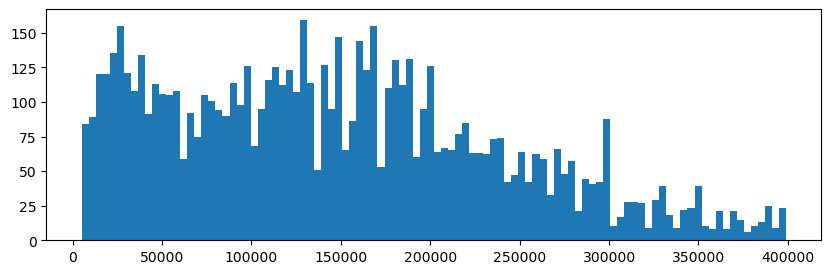

*The number of train data to be encoded: 130984
*The numer of train non-zeroes in the encoded matrix: 125967
The two numbers may differ, as some detections used keyword synonyms for the same e1 minor features. DEBUGNB! Assertion itself has thus has been removed.
*Dense train all cells: 636233
*Dense train cells full: 125967
*Percent full train, thus: 0.19798878712672874
*Not performing the sparse sanity check, as only top 2 made the cut
*Sparse train all cells: 256828
*Sparse train cells full: 30407
*Percent full train, thus: 0.11839441182425592
*Training losses: 0.02853379885318108, which is 4593 out of 160967
there_is_sparse_part: True
there_is_sparse_part: True
short_mean
shortest_mean
short_max
shortest_max


/home/realestate/anaconda3/envs/bnd/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/realestate/anaconda3/envs/bnd/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_13804/4162485369.py:13: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(project='jaanbi/bnd-regression', \


https://app.neptune.ai/jaanbi/bnd-regression/e/BND-327
*Running model: pr-400k-TRUE-FALSE-TRUE-0.2-480-10k
*The final train dataset has: 5837 rows and 420 columns
*The final test dataset has: 1459 rows and 420 columns


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

260.35000357600074


/home/realestate/anaconda3/envs/bnd/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/realestate/anaconda3/envs/bnd/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/home/realestate/anaconda3/envs/bnd/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [22]:
model_results_dictionaries = optimize(model_run_dictionaries, df_selected_projected, df_aptms)

In [24]:
with open('../pickles/model_results_dictionaries/model_results_dictionaries_79.pkl', 'wb') as f:
    pickle.dump(model_results_dictionaries, f)

## TODO

In [27]:
# directions to go:
# a) xgboost
# b) NB! DONE!!!!,
#    keyword extraction bug # NB!!! Bug: loc_LeisureRecreat	pikakari ja stroomi rand	4107	0.409880; THIS COULD POSSIBLY NOT BE 41% WITHIN THE MAJOR CATEGORY - MUST BE A BUG
# c) feature importances
# d) russian language text off